# Homogeneous Transformations

In [1]:
import scipy as sp
import numpy as np
%matplotlib widget
np.set_printoptions(precision=1, suppress=True)
from scipy.spatial.transform import Rotation
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def rotation_matrix(eulers):
    """
    Returns a rotation matrix (or matrices) from Euler angles
    (or a list/array of Euler angles).
    """
    R01 = Rotation.from_euler('xyz', eulers, degrees=True)
    T01 = R01.as_matrix()
    return T01

In [3]:
def htm(rm, dv):
    """
    Function to turn rotation matrix and displacement vector
    into a homogenous transformation matrix.  Handles a list
    or a list of rotation and displacement vectors.
    
    To move a point p_new = T x homogenous coordinate (4).
       Given this order of multimplication:
       1. Rotation ... then
       2. displacement
       
    """
    assert len(rm.shape) == len(dv.shape), f"Dimensions must match d(rm)={len(rm.shape)} but d(dv)={len(dv.shape)}"
    wrm, wdv  = rm, dv
    if len(rm.shape) == 2:
        wrm, wdv = np.array([rm]), np.array([dv])
    # print(f"rot matrix shape = {wrm.shape}")
    # print(f"dis matrix shape = {wdv.shape}")
    M34=np.concatenate([wrm, wdv], axis=2)
    # print(f"M34 matrix shape = {M34.shape}")
    new_row = np.array(M34.shape[0]*[[[0, 0, 0, 1]]])
    # print(f"new_row shape = {new_row.shape}")
    M44=np.concatenate([M34, new_row], axis=1)
    if len(rm.shape) == 2:
        M44 = M44[0]
    return M44
    

In [4]:
R_50 = rotation_matrix([0,0,50])

In [13]:
I = np.eye(3)
gx = lambda M: M[:,[0]]
gy = lambda M: M[:,[1]]
gz = lambda M: M[:,[2]]
ih, jh, kh = gx(I), gy(I), gz(I)
Z = np.zeros(I.shape)

In [14]:
print(*I.tolist())

[1.0, 0.0, 0.0] [0.0, 1.0, 0.0] [0.0, 0.0, 1.0]


In [ ]:
def plot_vector(ax, v, **kwargs):
    ax.arrow(zeros.shape(v)

In [19]:
print(*ih[0])

1.0


/home/wes/Documents/JupyterShelf/JupyEnv/lib/python3.9/site-packages/matplotlib/patches.py:1355: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  left_half_arrow = np.array([


ValueError: operands could not be broadcast together with shapes (8,2) (2,1) 

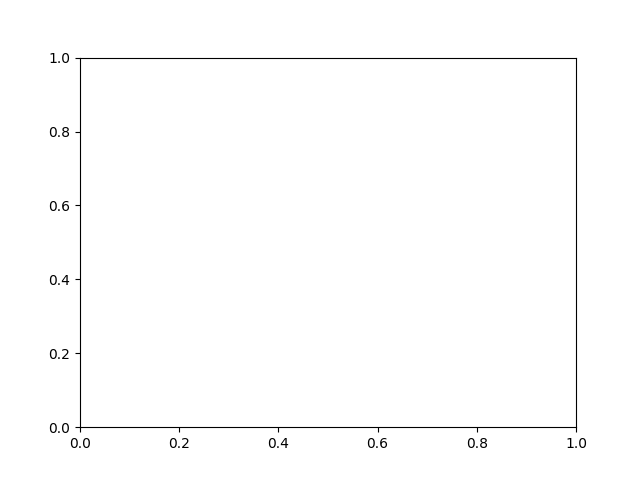

In [18]:
ax = plt.figure().add_subplot()
ax.arrow(0,*ih, color='b')
ax.arrow(0,0,0,1, color='r')
plt.show()

## 3D Plotting

[This](https://gist.github.com/WesErg/285e3d6a61e242a7c0609168285a1cf7) (forked) gist explains how to add 3D arrows to matplotlib.  (Peter Ernst's gists [page](https://gist.github.com/WetHat) is just awesome).

In [8]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)


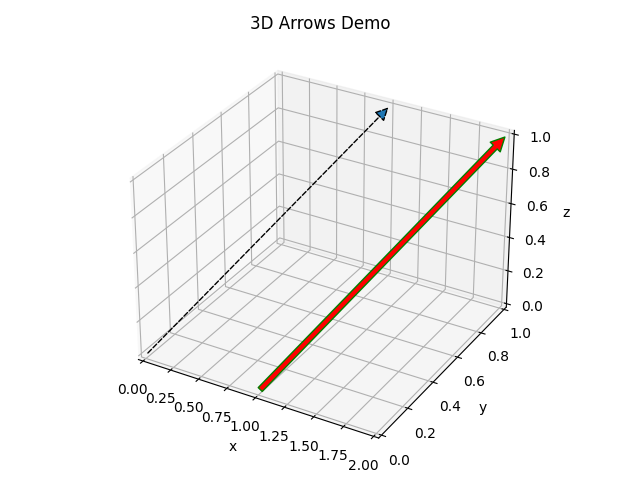

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0,2)
ax.arrow3D(0,0,0,
           1,1,1,
           mutation_scale=20,
           arrowstyle="-|>",
           linestyle='dashed')
ax.arrow3D(1,0,0,
           1,1,1,
           mutation_scale=20,
           ec ='green',
           fc='red')
ax.set_title('3D Arrows Demo')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.tight_layout()